In [2]:
!git clone https://github.com/openai/point-e
! pip install -e . -q

Cloning into 'point-e'...


In [1]:
cd point-e

D:\Jupyter notebook\point-e


C:\Users\bhara\anaconda3\envs\torch3d\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import torch
from PIL import Image
from tqdm.auto import tqdm
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load base and upsampler models (shared for both text and image modes)
def load_models(base_name):
    base_model = model_from_config(MODEL_CONFIGS[base_name], device)
    base_model.load_state_dict(load_checkpoint(base_name, device))
    base_model.eval()
    base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

    upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
    upsampler_model.load_state_dict(load_checkpoint('upsample', device))
    upsampler_model.eval()
    upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

    return base_model, upsampler_model, base_diffusion, upsampler_diffusion

In [8]:
# Generate 3D point cloud from image
def image_to_3d(image_path):
    base_model, upsampler_model, base_diffusion, upsampler_diffusion = load_models('base40M')
    sampler = PointCloudSampler(
        device=device,
        models=[base_model, upsampler_model],
        diffusions=[base_diffusion, upsampler_diffusion],
        num_points=[1024, 4096 - 1024],
        aux_channels=['R', 'G', 'B'],
        guidance_scale=[3.0, 3.0],
    )
    img = Image.open(image_path).convert("RGB")
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
        samples = x
    pc = sampler.output_to_point_clouds(samples)[0]
    return pc

In [9]:
def text_to_3d(prompt):
    base_model, upsampler_model, base_diffusion, upsampler_diffusion = load_models('base40M-textvec')
    sampler = PointCloudSampler(
        device=device,
        models=[base_model, upsampler_model],
        diffusions=[base_diffusion, upsampler_diffusion],
        num_points=[1024, 4096 - 1024],
        aux_channels=['R', 'G', 'B'],
        guidance_scale=[3.0, 0.0],
        model_kwargs_key_filter=('texts', '')
    )
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
        samples = x
    pc = sampler.output_to_point_clouds(samples)[0]
    return pc

In [10]:
# Plot point cloud with plotly
def plot_pointcloud(pc, render_mode='browser'):
    pio.renderers.default = render_mode
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:, 0],
                y=pc.coords[:, 1],
                z=pc.coords[:, 2],
                mode='markers',
                marker=dict(
                    size=2,
                    color=[
                        f'rgb({r},{g},{b})'
                        for r, g, b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])
                    ],
                )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            ),
            margin=dict(l=0, r=0, b=0, t=0)
        )
    )
    fig.show()

In [12]:
# Save point cloud to .obj file
def save_pointcloud_to_obj(pc, filename="output.obj"):
    with open(filename, 'w') as f:
        for (x, y, z), r, g, b in zip(pc.coords, pc.channels["R"], pc.channels["G"], pc.channels["B"]):
            f.write(f"v {x} {y} {z} {r/255:.2f} {g/255:.2f} {b/255:.2f}\n")
    print(f"Saved to {filename}")

In [25]:
img = Image.open("knife.jpg")

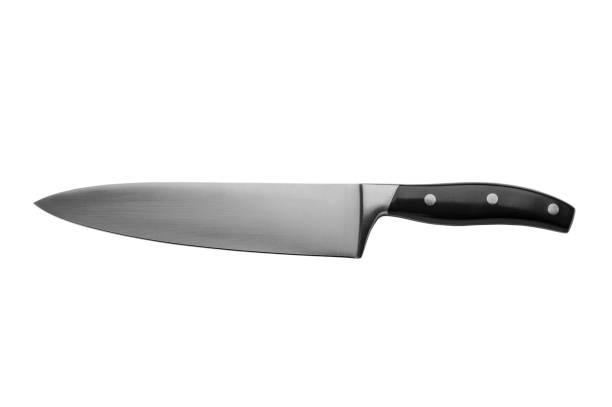

In [26]:
img

In [28]:
# For image input
pc_image = image_to_3d("knife.jpg")
save_pointcloud_to_obj(pc_image, "image_model.obj")

0it [00:00, ?it/s]

Saved to image_model.obj


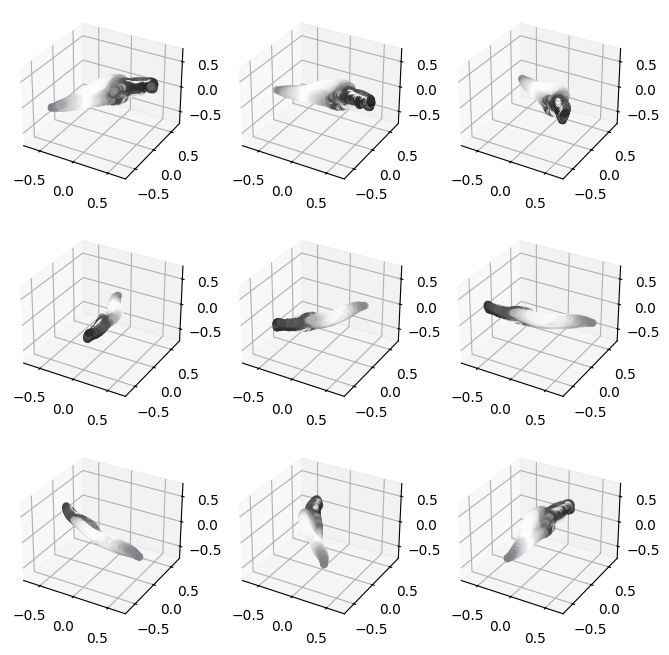

In [29]:
fig = plot_point_cloud(pc_image, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [30]:
plot_pointcloud(pc_image, render_mode='browser')  # or 'notebook'

In [ ]:
# For text input
pc_text = text_to_3d("a small toy car")
save_pointcloud_to_obj(pc_text, "text_model.obj") 

0it [00:00, ?it/s]

In [ ]:
fig = plot_point_cloud(pc_text, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
plot_pointcloud(pc_text,render_mode='browser')